# **Spam Detector**
#### Creating a simple spam identifier with techniques from Text Preprocessing and Machine Learning

## **Context**
**Many users worldwide rely on email and text messages** for communication, and these have become an essential part of daily life. 

Emails and text messages, due to their importance to people's lives worldwide, may also however contain sensitive information that hackers could attempt to steal (data theft). As a result, it is often critical for email service providers to be able to distinguish between spam and ham (not spam) emails, to reduce the likelihood of a user suffering a data theft attack.

Genuine email/text that is important to the user and informative, is referred to as ham. Spam, on the other hand, is bogus email/text sent from untrustworthy sources with malicious intent.

## **Data Dictionary**
* **Text:** Messages sent by the users
* **Type:** Target variable which provides the label about a message being Spam or Ham

Due to the presence of the **Type** label, this is of course just a **Supervised Learning Classification** problem of classifying if the Text is Spam or Ham. 

The catch is that **we don't explicitly have features (columns) in our data** - we only have the text of each message, and we have to attempt to **"extract"** numerical features from this text to feed into the Machine Learning algorithms we have already learnt before, to see if that is able to identify Ham vs Spam messages. 

As we will see in the rest of this notebook, the text preprocessing methods we have learnt so far, do in fact give us an initial level of success in this task. 

In [1]:
!pip install Unidecode
!pip install autocorrect

     |████████████████████████████████| 622 kB 3.5 MB/s eta 0:00:01
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622382 sha256=4c32104fef6df84bb0bc71d2bf543811cbb83056c6cf30d96c5f967b4e9154e7
  Stored in directory: /Users/manishsingh/Library/Caches/pip/wheels/ab/0f/23/3c010c3fd877b962146e7765f9e9b08026cac8b035094c5750
Successfully built autocorrect


## **Importing the necessary libraries**

In [2]:
# Importing the required the libraries

# To read and manipulate the data
import pandas as pd
pd.set_option('max_colwidth', None)

# To visualise the graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Helps to display the images
from PIL import Image

# Helps to extract the data using regular expressions
import re

# Helps to remove the punctuation
import string

# It helps to remove the accented characters 

import unidecode

# It help to correct the spellings

from autocorrect import Speller


# Importing the NLTK library
import nltk

nltk.download('stopwords')    # Loading the stopwords
nltk.download('punkt')        # Loading the punkt module, used in Tokenization
nltk.download('omw-1.4')      # Dependency for Tokenization
nltk.download('wordnet')      # Loading the wordnet module, used in stemming and lemmatization

from nltk.corpus import stopwords

# Helps to visualize the wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Used in Stemming
from nltk.stem.porter import PorterStemmer

from nltk.stem import SnowballStemmer

from nltk.stem import LancasterStemmer

# Used in Lemmatization
from nltk.stem import WordNetLemmatizer

# Used in Tokenization
from nltk.tokenize import word_tokenize, sent_tokenize

# Importing the SpaCy library 
import spacy

nlp = spacy.load('en_core_web_sm')  # Loading the envrionment config

# Used in tokenization
from spacy.lang.en import English
en_nlp = English()

# Helped to create train and test data
from sklearn.model_selection import train_test_split

# Importing the Random Forest model
from sklearn.ensemble import RandomForestClassifier

# Metrics to evaluate the model
from sklearn.metrics import accuracy_score,classification_report

[nltk_data] Error loading stopwords: <urlopen error [Errno 60]
[nltk_data]     Operation timed out>
[nltk_data] Error loading punkt: <urlopen error [Errno 60] Operation
[nltk_data]     timed out>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 60] Operation
[nltk_data]     timed out>
[nltk_data] Error loading wordnet: <urlopen error [Errno 60] Operation
[nltk_data]     timed out>
2023-05-17 19:01:51.210012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## **Loading the dataset**

In [4]:
# mounting the google drive
#from google.colab import drive
#drive.mount('/content/drive')

# Loading the data
messages = pd.read_csv("sms_spam.csv")

In [5]:
# Creating a copy of the data frame
data = messages.copy()

## **Overview of the dataset**

### **View the first and last 5 rows of the dataset**

In [6]:
data.head()

,type,text
0,ham,Hope you are having a good week. Just checking in ñó ñó
1,ham,K..going bacckk to stävänger
2,ham,Am also dong in cbe ony. Bt have to pay
3,ham,Are you this much buzy
4,ham,Please ask mummy to call father


In [7]:
data.tail()

,type,text
5055,spam,Sunshine Quiz Wkly Q! Win a top Sony DVD player if u know which country Liverpool played in mid week? Txt ansr to 82277. £1.50 SP:Tyrone
5056,spam,"HOT LIVE FANTASIES call now 08707509020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national rate call"
5057,spam,Ur balance is now £500. Ur next question is: Who sang 'Uptown Girl' in the 80's ? 2 answer txt ur ANSWER to 83600. Good luck!
5058,spam,"If you don't, your prize will go to another customer. T&C at www.t-c.biz 18+ 150p/min Polo Ltd Suite 373 London W1J 6HL Please call back if busy"
5059,spam,"SMS. ac JSco: Energy is high, but u may not know where 2channel it. 2day ur leadership skills r strong. Psychic? Reply ANS w/question. End? Reply END JSCO"


### **Understand the shape of the dataset**

In [8]:
data.shape

(5060, 2)

* The dataset has 5060 rows and 2 columns. 

### **Check the data types of the columns for the dataset**

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5060 entries, 0 to 5059
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    5060 non-null   object
 1   text    5060 non-null   object
dtypes: object(2)
memory usage: 79.2+ KB


* Both the columns are of the object type.
* There are no null values in the dataset, so no missing values.

### **Checking for duplicate values**

In [10]:
# checking for duplicate values
data.duplicated().sum()

383

In [11]:
# dropping the duplicates
data = data.drop_duplicates(keep = 'first')

# checking for duplicate values
data.duplicated().sum()

0

In [12]:
# resetting the index of the dataframe
data = data.reset_index(drop = True)

* The duplicate values have been removed.

## **Exploratory Data Analysis**

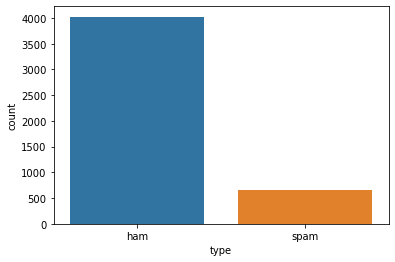

--------------------------------------------------
ham     0.860381
spam    0.139619
Name: type, dtype: float64


In [13]:
# Lets look at the distribution of ham and spam messages
sns.countplot(x = 'type', data = data)
plt.show()

print("-"*50)

# checking the percentage of ham and spam messages
print(data['type'].value_counts(normalize = True))

* 86% of the messages in the dataset are ham, so **only around 14% of the messages are actually spam.**
* This dataset is hence highly imbalanced.

This is quite reflective of the use cases where Machine Learning is generally required, even in the NLP space. **In general, the event / occurrence we're trying to identify is rare**, and that's the value of Machine Learning and AI - being able to detect that needle in the haystack; in this case detecting the one spam message from a crowd of non-spam, which would obviously be critical to the utility of a good spam detector.

### **Let's now take a look at some of the messages in the data to get a sense for the text preprocessing required**

In [14]:
data['text'][6]

'       Sure thing big man. i have hockey elections at 6, shouldn€˜t go on longer than an hour though     '

In [15]:
data['text'][0]

'Hope you are having a good week. Just checking in ñó ñó'

In [16]:
data['text'][4320]

'URGENT! We are trying to contact U. Todays draw shows that you have won a £800 prize GUARANTEED. Call 09050001808 from land line. Claim M95. Valid12hrs only'

In [17]:
data['text'][4330]

'Thanks for your Ringtone Order, Reference T91. You will be charged GBP 4 per week. You can unsubscribe at anytime by calling customer services on 09057039994'

**From the random samples seen above, we observe that the text has:**

*  Extra spaces

*  Accented and Special characters

*  Misspelled words

*  Word inflections - can be observed in row 4320 where words like awarded and guaranteed can be reduced to their base forms.

*  Lowercase and Uppercase characters


**The presence of such unwanted text doesn't add any value and also impacts the learning of a model**, thus reducing the model's performance. 

Hence, we shall be removing such unwanted text.

### **Let's first build a Random Forest model without performing any text preprocessing and observe the results**

In [18]:
uncleaned_data = data.copy()

In [19]:
X = uncleaned_data["text"]
Y = uncleaned_data["type"].map({'ham':0,'spam':1})
# encoding the features
X = pd.get_dummies(X, drop_first=True)

# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 1,stratify = Y)

In [43]:
X.head()

,# in mca. But not conform.,# mins but i had to stop somewhere first.,DECIMAL m but its not a common car here so its better to buy from china or asia. Or if i find it less expensive. I.ll holla,and picking them up from various points,"came to look at the flat, seems ok, in his 50s? * Is away alot wiv work. Got woman coming at 6.30 too.",gonna let me know cos comes bak from holiday that day. is coming. Don't4get2text me number.,"said kiss, kiss, i can't do the sound effects! He is a gorgeous man isn't he! Kind of person who needs a smile to brighten his day!","says that he's quitting at least5times a day so i wudn't take much notice of that. Nah, she didn't mind. Are you gonna see him again? Do you want to come to taunton tonight? U can tell me all about !",what number do u live at? Is it 11?,# am I think? Should say on syllabus,...,"whatever, im pretty pissed off.",when you and derek done with class?,will you like to be spoiled? :),wiskey Brandy Rum Gin Beer Vodka Scotch Shampain Wine KUDIyarasu dhina vaazhthukkal. ..,would u believe it they didnt know i had thurs pre booked off so they re cancelled me AGAIN! that needs to b sacked,"wow. You're right! I didn't mean to do that. I guess once i gave up on boston men and changed my search location to nyc, something changed. Cuz on my signin page it still says boston.",yay! finally lol. i missed our cinema trip last week :-(,yeah sure thing mate haunt got all my stuff sorted but im going sound anyway promoting hex for .by the way who is this? dont know number. Joke,"yeah, that's what I was thinking","you are sweet as well, princess. Please tell me your likes and dislikes in bed..."
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (3741, 4676)
Shape of test set :  (936, 4676)
Percentage of classes in training set:
0    0.860465
1    0.139535
Name: type, dtype: float64
Percentage of classes in test set:
0    0.860043
1    0.139957
Name: type, dtype: float64


In [21]:
# intializing the Random Forest model
model = RandomForestClassifier(random_state=1)

# fitting the model on training set
model.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

In [22]:
# making predictions on the test set
y_pred = model.predict(X_test)

# checking the metrics
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92       936
           1       0.00      0.00      0.00         0

    accuracy                           0.86       936
   macro avg       0.50      0.43      0.46       936
weighted avg       1.00      0.86      0.92       936



/Users/manishsingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manishsingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manishsingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- The model (even a fairly strong model such as the Random Forest) does not seem to be able to differentiate between ham and spam messages, and is simply predicting everything to be ham.
- This appears to be a major drawback of using unclean text data.


**Now that we know performance on unclean data is very poor, let's clean the data with text preprocessing techniques** 

## **Text Preprocessing Step 1**
## **Removing accented characters from the text**

* Accents are special string characters generally adapted from other languages. They are not considered a major part of English.
* By using the unidecode library, we can transliterate any unicode string into the closest possible representation in ASCII text.

In [23]:
# Let's look at the first two text messages
data['text'][0:2]

0    Hope you are having a good week. Just checking in ñó ñó
1                               K..going bacckk to stävänger
Name: text, dtype: object

We can see above that 'no no' and 'stavanger' are words with accented characters.

In [24]:
# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):

    t = data['text'][i].split()
    # Applying the unicode data on a sentence and replacing the accented words to get the closest possible ASCII text
    new_text = [unidecode.unidecode(word) for word in t]
    
    # Combining the seperate words into sentence
    new_text = ' '.join(new_text)
    # append the new_text to list text
    text.append(new_text)

data['cleaned_text'] = text

In [25]:
data.loc[0:3,['text','cleaned_text']]

,text,cleaned_text
0,Hope you are having a good week. Just checking in ñó ñó,Hope you are having a good week. Just checking in no no
1,K..going bacckk to stävänger,K..going bacckk to stavanger
2,Am also dong in cbe ony. Bt have to pay,Am also dong in cbe ony. Bt have to pay
3,Are you this much buzy,Are you this much buzy


- We observe that the accented words are now converted to normal words i.e **stävänger** to **stavanger** and **ñó** to no.	

## **Text Preprocessing Step 2**
## **Removing special characters from the text**

The function **isalnum()** method returns `True` if all the characters are alphanumeric, meaning alphabet letter (a-z) and numbers (0-9). By using this function we can retrive the data which consists of only letters and numbers.

In [26]:
# let's consider the below example
data['text'][75]

'Yup bathe liao...'

* We can see that `liao...` has special symbols or extra punctuation in the text and this needs to be removed.

In [27]:
# splitting text into separate words
example = data['text'][75].split()
example

['Yup', 'bathe', 'liao...']

In [28]:
# defining an empty list
text = []

# looping over each element of the list
for i in example:
  if i.isalnum():  # checking if the element is an alphabet or a number
    new_text = i   # if the element of the list is a number assign it to variable new_text
    text.append(new_text) # append the new_text to empty list text

print('New list with only alphabets and numbers: ', text)

# retriving the original text
# join() is an inbuilt string function in Python takes all items in an iterable and joins them into one string. 
print('Original Text: ',' '.join(text))

New list with only alphabets and numbers:  ['Yup', 'bathe']
Original Text:  Yup bathe


### **Now let's apply the above steps to all the messages in the dataset**

In [29]:
# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):
    words = data['cleaned_text'][i].split() # splitting text into separate words
    new_text = ' '.join([element for element in words if element.isalnum()]) # looping over each element of the list and using the join() function to retrive the original text
    text.append(new_text)  # append the new_text to empty list text
    
data['cleaned_text'] = text  

Let's take a look at some random samples to view the messages now

In [30]:
data.loc[[1,10,75,76,77,78],['text','cleaned_text']]

,text,cleaned_text
1,K..going bacckk to stävänger,bacckk to stavanger
10,K I'll be sure to get up before noon and see what's what,K be sure to get up before noon and see what
75,Yup bathe liao...,Yup bathe
76,I am getting threats from your sales executive Shifad as i raised complaint against him. Its an official message.,I am getting threats from your sales executive Shifad as i raised complaint against Its an official
77,S.this will increase the chance of winning.,will increase the chance of
78,How are you doing. How's the queen. Are you going for the royal wedding,How are you the Are you going for the royal wedding


* **isalnum()** has removed the special characters from the text successfully.
* If we observe the text closely, the words attached with the special characters have also been removed.
* For example, in the text 'Yup bathe liao...' the word 'liao...' is removed as it was attached to special characters.
* **isalnum()** is a stringent function and works well when the special characters are separated by a white space character or space.
* Another efficient way to deal with special characters is to use the **regex** library. 

In [31]:
# importing regex library
import re


# defining an empty list
text = []

# Specifying the pattern for regex to match a string of characters that are not a letters or numbers 
# regex will look for alphabets A to Z, a to z, and numbers 0 to 9
pattern = '[^A-Za-z0-9]+'

# looping over each message in the data
for i in range(data.shape[0]):

    words = data['cleaned_text'][i].split() # splitting text into separate words
    new_text = ''.join(re.sub(pattern, ' ', data['cleaned_text'][i])) # finding the pattern and using the join() function to retrive the original text
    text.append(new_text) # append the new_text to empty list text
    
data['cleaned_text'] = text  

Let's take a look at some random samples to view the text now.

In [32]:
data.loc[[1,10,75,76,77,78],['text','cleaned_text']]

,text,cleaned_text
1,K..going bacckk to stävänger,bacckk to stavanger
10,K I'll be sure to get up before noon and see what's what,K be sure to get up before noon and see what
75,Yup bathe liao...,Yup bathe
76,I am getting threats from your sales executive Shifad as i raised complaint against him. Its an official message.,I am getting threats from your sales executive Shifad as i raised complaint against Its an official
77,S.this will increase the chance of winning.,will increase the chance of
78,How are you doing. How's the queen. Are you going for the royal wedding,How are you the Are you going for the royal wedding


- We can observe that regex simply removed the special characters and retained the alphabets and numbers.

## **Text Preprocessing Step 3**
## **Lowercasing**

* **Lowercasing is an important text preprocessing technique.** The goal is to change the input text's case so that the words "text," "Text," and "TEXT" are all treated equally. Strings in Python are of course case-sensitive, so Python will not automatically do this for us.
* Lowercasing helps reduce duplication and obtain accurate counts - it is hence an important part of various **"feature extraction"** approaches for text data.

In [33]:
# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):
    # lowecasing the text using the lower() function
    new_text = data['cleaned_text'][i].lower()
    text.append(new_text) # append the new_text to empty list text

data['cleaned_text'] = text

Let's take a look at some random samples now:

In [34]:
data.loc[4320:4322,['text','cleaned_text']]

,text,cleaned_text
4320,URGENT! We are trying to contact U. Todays draw shows that you have won a £800 prize GUARANTEED. Call 09050001808 from land line. Claim M95. Valid12hrs only,we are trying to contact todays draw shows that you have won a ps800 prize call 09050001808 from land claim valid12hrs only
4321,Bloomberg -Message center +447797706009 Why wait? Apply for your future http://careers. bloomberg.com,bloomberg center why apply for your future
4322,WIN a £200 Shopping spree every WEEK Starting NOW. 2 play text STORE to 88039. SkilGme. TsCs08714740323 1Winawk! age16 £1.50perweeksub.,win a ps200 shopping spree every week starting 2 play text store to tscs08714740323 age16


- We can observe that, all the text has now successfully been converted to lower case.

## **Text Preprocessing Step 4**
## **Stripping Extra Spaces**

* Stripping helps remove spaces at the beginning and the end of the string/sentence. 
* The extra spaces in between the characters and the spaces at the start or end of the string do not add any value to the model, and will rather slow down its computation speed. 

Thus, we can remove these extra spaces to make the model more efficient and targeted during the training process.

In [35]:
# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):
    # removing extra spaces from the text using strip() function
    new_text = data['cleaned_text'][i].strip() 
    text.append(new_text)  # append the new_text to empty list text
    
data['cleaned_text'] = text

In [36]:
print("Before stripping the text data:",data['text'][6])
print("After stripping the text data:",data['cleaned_text'][6])

Before stripping the text data:        Sure thing big man. i have hockey elections at 6, shouldn€˜t go on longer than an hour though     
After stripping the text data: sure thing big i have hockey elections at go on longer than an hour though


- We now see that we have eliminated redundant extra spaces from the text.

As we have now performed lowercasing, removed the special & accented characters and numbers, and also stripped the text of its extra spaces, **this would be a good time to correct misspelled words**, since the unwanted text has now been removed.

## **Text Preprocessing Step 5**
## **Spellchecking**

In [37]:
#!pip install autocorrect

In [38]:
# intializing the spellchecker and setting the language to english
spell = Speller(lang = 'en')

# defining a function which will take text as an input break
def autospell(text):
  '''
  A function which takes text as an input, performs a spell check, and autocorrects misspelled words  
  text: text input (object)
  '''
  word = text.split() # splitting text into separate words 
  spells = [spell(w) for w in word] # Spell checking on each word
  return " ".join(spells) # retriving the original text

In [39]:
# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):
    # applying the autospell function on the text messages
    new_text = autospell(data['cleaned_text'][i]) 
    text.append(new_text) # append the new_text to empty list text

data['cleaned_text'] = text

In [40]:
# Now have a look at the spell corrected words
data.loc[0:2,['text','cleaned_text']]

,text,cleaned_text
0,Hope you are having a good week. Just checking in ñó ñó,hope you are having a good just checking in no no
1,K..going bacckk to stävänger,back to stranger
2,Am also dong in cbe ony. Bt have to pay,am also dong in cbe bt have to pay


- We observe that the spell correction seems to have worked but is not at its best. 
- For row 1, 'bacckk' was corrected to back but it didn't work well for row 2 where many misspelled words were left as is.

## **Text Preprocessing Step 6**
## **Stop word Removal**

* The simple idea with stop word removal is to **exclude words that appear frequently throughout** all the documents in the corpus. Pronouns and articles are typically categorized as stop words.

* To implement this, we have two Python libraries that are built to be used for NLP operations. Let's have a look at them and we'll implement them through both libraries.

**Before removing the stop words from the text however, let's have a look at the key words from the original data through visual representation.**

### **Word Cloud**

A word cloud (also known as a tag cloud or text cloud) is a **visual representation of text**, in which the words appear bigger the more often they are mentioned. Word clouds are great for visualizing unstructured text data and getting insights on trends and patterns.



**Let's look at the top 100 unique words in original messages**

In [44]:
all_texts = " ".join(texts for texts in data.text)
print ("There are {} words in the combination of all texts.".format(len(all_texts)))

# lower max_font_size, change the maximum number of word and lighten the background:
#wordcloud = WordCloud(max_font_size = 40, max_words=100, background_color="white").generate(all_texts)
#plt.figure(figsize=(8,12))
#plt.imshow(wordcloud)
#plt.axis("off")
#plt.show()

There are 366171 words in the combination of all texts.


**Let's look at the top 100 unique words in the messages where we have applied some text preprocessing steps**

In [45]:
all_texts = " ".join(texts for texts in data.cleaned_text)
print ("There are {} words in the combination of all texts.".format(len(all_texts)))

# lower max_font_size, change the maximum number of word and lighten the background:
#wordcloud = WordCloud(max_font_size = 40, max_words=100, background_color="white").generate(all_texts)
#plt.figure(figsize=(8,12))
#plt.imshow(wordcloud)
#plt.axis("off")
#plt.show()

There are 274650 words in the combination of all texts.


- As we see, there were 366,171 words in the data before preprocessing and 274,650 words after the preprocessing.

### **Removing the stop words using the NLTK library**

NLTK has an in-built list of stop words, and it can utilize that list to remove the stop words from the dataset.

In [46]:
# defining an empty list
text = []

for i in range(data.shape[0]):
    
    word = data['cleaned_text'][i].split() # splitting text into separate words 
    # removing the english language stopwords from the messages
    new_text = [w for w in word if not w in stopwords.words('english')] 
    new_text = ' '.join(new_text) #retriving the original text
    text.append(new_text) # 
    
data['NLTK_nostopwords_text'] = text 

In [47]:
data.loc[6:8,['cleaned_text','NLTK_nostopwords_text']]

,cleaned_text,NLTK_nostopwords_text
6,sure thing big i have hockey elections at go on longer than an hour though,sure thing big hockey elections go longer hour though
7,i anything,anything
8,by march i should be but will call you for the problem is that my capital never how far with work and the ladies,march call problem capital never far work ladies


- We observe that stop words are removed from the text column. 
- For row 6, `i have`, `at` and `than an` are removed. 
- In row 7, **i** character was removed.

### **After stop words removal**

In [48]:
all_texts1 = " ".join(texts for texts in data.NLTK_nostopwords_text)

print ("There are {} words in the combination of all texts.".format(len(all_texts1)))

# lower max_font_size, change the maximum number of word and lighten the background:
#wordcloud = WordCloud(max_font_size = 40, max_words=100, background_color="white").generate(all_texts1)
#plt.figure(figsize=(8,12))
#plt.imshow(wordcloud)
#plt.axis("off")
#plt.show()

There are 177931 words in the combination of all texts.


- We now have 177,931 words after the stop words removal from the cleaned_text.

### **Let's now implement the same with the spaCy library**

Similar to NLTK, spaCy also has its list of stop words. Let's see how spaCy performs.

In [49]:
# Loading the english language small model of spacy
en = spacy.load('en_core_web_sm')

# loading the stopwords
spacy_stopwords = en.Defaults.stop_words

In [50]:
# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):
  t = data['cleaned_text'][i].split() # splitting text into separate words 
  # Removing the words that are present in the stopwords
  words = [word for word in t if not word in spacy_stopwords] 
  words = ' '.join(words) #retriving the original text
  text.append(words) # append the new_text to empty list text
    
data['spacy_nostopwords_text'] = text 

**Let's have a comparison for both NLTK results and spaCy results to check how well they removed stop words**

In [51]:
data.loc[100:105,['cleaned_text','spacy_nostopwords_text','NLTK_nostopwords_text']]

,cleaned_text,spacy_nostopwords_text,NLTK_nostopwords_text
100,i crashed out muddled on my,crashed muddled,crashed muddled
101,dont show how put new pictures up on,dont new pictures,dont show put new pictures
102,i grumpy old my mom was like you better not be then again i am always the one to play,grumpy old mom like better play,grumpy old mom like better always one play
103,boo on my way to my making gorilla mmmm,boo way making gorilla mmmm,boo way making gorilla mmmm
104,what not under,,
105,so you think i should actually talk to not call his boss in the i went to this place last year and he told me where i could go and get my car fixed he kept telling me today how much he hoped i would come back how he always regretted not getting my,think actually talk boss went place year told car fixed kept telling today hoped come regretted getting,think actually talk call boss went place last year told could go get car fixed kept telling today much hoped would come back always regretted getting


From the above results, we can see that both libraries have performed decently and have been able to remove stop words. 

Let's look at how many words are left in the data after removing stop words using spaCy.

### **Results of spaCy through word cloud**

In [52]:
all_texts2 = " ".join(texts for texts in data.spacy_nostopwords_text)

print ("There are {} words in the combination of all texts.".format(len(all_texts2)))

# lower max_font_size, change the maximum number of word and lighten the background:
#wordcloud = WordCloud(max_font_size = 40, max_words = 200, background_color = "white").generate(all_texts2)
#plt.figure(figsize = (8,12))

#plt.imshow(wordcloud)
#plt.axis("off")
#plt.show()

There are 156370 words in the combination of all texts.


- We got 156,370 after the stop word removal from the cleaned_text.
- We can see that spaCy has been able to remove more stop words in comparison to NLTK.

We'll use text output with no stop words given by spaCy for further steps.

Now that stop words have been removed and the text doesn't contain unnecessary characters or words. Let's now apply the **stemming** and **lemmatization** techniques to reduce words to their base forms.

## **Text Preprocessing Step 7**
## **Stemming**

We have three types of stemmers available in the NLTK library:

- **Porter Stemmer**
- **Snowball Stemmer**
- **Lancaster Stemmer**

**Note:** spaCy doesn't contain any function for stemming - it only provides support for lemmatization.

We are going to store each stemming technique's results into separate columns, so that different models can be built on these outputs and we can observe which stemming method works the best.

### **Porter Stemmer**

In [53]:
# Initializing the Porter Stemmer
ps = PorterStemmer()

# defining empty list for porter stemmer output
porter_stems = []

# looping over each message in the data
for i in range(data.shape[0]):
  text = data['spacy_nostopwords_text'][i].split() # splitting text into separate words 
  new_text = [ps.stem(word) for word in text] # applying the porter stemmer on every word of a mesaage
  new_text = ' '.join(new_text) #retriving the original text
  porter_stems.append(new_text) # append the text with base form of words in a message to empty list text
    
data['porter_text'] = porter_stems

In [54]:
data.loc[70:74,['spacy_nostopwords_text','porter_text']]

,spacy_nostopwords_text,porter_text
70,hey tmr maybe meet yck,hey tmr mayb meet yck
71,ok coming home,ok come home
72,u called dad,u call dad
73,head text meet,head text meet
74,miss surprised gone net cafe miss,miss surpris gone net cafe miss


- If we observe the 70th and 73rd row, no word is converted into its root word since every word in the sentence already is in its base form.
- We can observe that in the 71st row, the **coming** word is changed to **come**. In 72nd row **called** changed to **call**.

### **Snowball Stemmer**

In [55]:
# Initializing the Snowball Stemmer
snowball = SnowballStemmer(language = 'english')

# defining empty list for snowball stemmer output
snow_stems = []

# looping over each message in the data
for i in range(data.shape[0]):
  text = data['spacy_nostopwords_text'][i].split() # splitting text into separate words 
  new_text = [snowball.stem(word) for word in text]  # applying the snowball stemmer on every word of a mesaage
  new_text = ' '.join(new_text) # retriving the original text
  snow_stems.append(new_text) # append the text with base form of words in a message to empty list text
    
data['snowball_text'] = snow_stems

In [56]:
data.loc[70:74,['spacy_nostopwords_text','snowball_text']]

,spacy_nostopwords_text,snowball_text
70,hey tmr maybe meet yck,hey tmr mayb meet yck
71,ok coming home,ok come home
72,u called dad,u call dad
73,head text meet,head text meet
74,miss surprised gone net cafe miss,miss surpris gone net cafe miss


- The Snowball stemmer seems to have given similar results to the Porter stemmer.

### **Lancaster Stemmer**

In [57]:
# Initializing the Lancaster Stemmer
lanc = LancasterStemmer()

# defining empty list for lancaster stemmer output
lanc_stems = []

# looping over each message in the data
for i in range(data.shape[0]):
  text = data['spacy_nostopwords_text'][i].split() # splitting text into separate words 
  new_text = [lanc.stem(word) for word in text] # applying the lancaster stemmer on every word of a mesaage
  new_text = ' '.join(new_text) # retriving the original text
  lanc_stems.append(new_text) # append the text with base form of words in a message to empty list text
    
data['lancast_text'] = lanc_stems

In [58]:
data.loc[70:74,['spacy_nostopwords_text','lancast_text']]

,spacy_nostopwords_text,lancast_text
70,hey tmr maybe meet yck,hey tmr mayb meet yck
71,ok coming home,ok com hom
72,u called dad,u cal dad
73,head text meet,head text meet
74,miss surprised gone net cafe miss,miss surpr gon net caf miss


- The Lancaster stemmer results are a bit different - if we observe the 71st row, **coming** and **home** are transformed into **com** and **hom**. 
- In the 74th row **surprised** was translated to **surpr**, **gone** to **gon** and **cafe** to **caf**.


The Lancaster stemmer being an aggresive stemmer in comparison to Porter and Snowball, has resulted in very different results.

**We have created the stem or root words for the text data using different stemming techniques. Now let's create lemmas for each word in the text using Lemmatization.**

## **Text Preprocessing Step 8**
## **Lemmatization**

### **Lemmatization using the NLTK Library**

Lemmatization is the transformation that uses a dictionary to map a word’s variant back to its root format.

In [59]:
# Implemenation using NLTK

# initiating Lemmatizer available in NLTK library
lemmatizer = WordNetLemmatizer()

# defining empty list for lemmatizer output
lemma = []

# looping over each message in the data
for i in range(data.shape[0]):
  text = data['spacy_nostopwords_text'][i].split()  # splitting text into separate words 
  new_text = [lemmatizer.lemmatize(word) for word in text] # perfoming lemmatization on every word of a mesaage
  new_text = ' '.join(new_text) # retriving the original text
  lemma.append(new_text) # append the text with base form of words in a message to empty list text

data['NLTK_lemmatized_text'] = lemma

In [60]:
data.loc[55:57,['spacy_nostopwords_text','NLTK_lemmatized_text']]

,spacy_nostopwords_text,NLTK_lemmatized_text
55,think send love,think send love
56,beautiful truth read heart feels light feels heavy leaves good night,beautiful truth read heart feel light feel heavy leaf good night
57,love think hope day goes sleep miss long moment,love think hope day go sleep miss long moment


- In row 56, **leaves** were wrongly transformed into **leaf**, since the "leaves" word is being used here in the context of the verb "leave".

### **Lemmatization using the spaCy Library**

In [61]:
# Implemenation using SpaCy
lemma_texts = []

# looping over each message in the data
for i in range(data.shape[0]):
  #  "nlp" Object is used to create documents with linguistic annotations.
  doc = nlp(data['spacy_nostopwords_text'][i])
  
  # Create list of sentence tokens
  lemma_list = []
  
  for token in doc:
    lemma_list.append(token.lemma_)
    lemma_text = ' '.join(lemma_list)
  
  lemma_texts.append(lemma_text)

data['spacy_lemmatized_text'] = lemma_texts 

In [62]:
data.loc[55:57,['spacy_nostopwords_text','spacy_lemmatized_text']]

,spacy_nostopwords_text,spacy_lemmatized_text
55,think send love,think send love
56,beautiful truth read heart feels light feels heavy leaves good night,beautiful truth read heart feel light feel heavy leave good night
57,love think hope day goes sleep miss long moment,love think hope day goes sleep miss long moment


- In comparison to the NLTK library output for lemmatization, in row 56 spaCy was able to hold the context of the sentence. It transformed **leaves** to **leave** which was more suitable than **leaf**.


**We have now successfully cleaned the text data and transformed it into root words using stemming and lemmatization.** 
* In order to check which of these techniques worked best for us, we can build models with each one of them. 
* We can compare the performance of the model with the Porter, Snowball, and Lancaster stemmers to see which of the stemming algorithms helped us predict Ham vs Spam the best
* Similarly, we can compare the model perfomance results of Stemming vs Lemmatization.

For the sake of this exercise and to see how text pre-processing has helped in improving the model performance, we will be using the text output received after removing the unnecessary rows.

## **Model Building**



In [63]:
cleaned_data = data.copy()

In [64]:
X = cleaned_data["NLTK_lemmatized_text"]

Y = cleaned_data["type"].map({'ham':0,'spam':1})

# encoding the features
X = pd.get_dummies(X, drop_first = True)

# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 1,stratify = Y)

In [65]:
print("Shape of Training set : ", X_train.shape)

print("Shape of test set : ", X_test.shape)

print("Percentage of classes in training set:")

print(y_train.value_counts(normalize = True))

print("Percentage of classes in test set:")

print(y_test.value_counts(normalize = True))

Shape of Training set :  (4209, 4330)
Shape of test set :  (468, 4330)
Percentage of classes in training set:
0    0.860299
1    0.139701
Name: type, dtype: float64
Percentage of classes in test set:
0    0.861111
1    0.138889
Name: type, dtype: float64


In [ ]:
# intializing the Random Forest model
model = RandomForestClassifier(random_state = 1)

# fitting the model on training set
model.fit(X_train, y_train)

In [ ]:
# making predictions on the test set
y_pred = model.predict(X_test)

# checking the metrics
print(classification_report(y_pred, y_test))

- As we can see, the model is now able to differentiate between ham and spam messages to some degree, as the performance of the model for class 1 has improved.
- The recall has improved, although the precision is not that great.

## **Conclusion**

* **We were hence able to establish the need for text preprocessing** by checking the performance of the model before and after preprocessing. It has clearly had some effect on improving our ability to identify spam messages.
* **This notebook is however only a naïve introduction to the large world of NLP.** We took the liberty to apply one-hot encoding, one of the simplest possible methods, to the text-based dataset to convert it into numerical features. 
* **One-hot encoding, as we will learn soon, is not the ideal approach for encoding text data.** In future video lectures, we will discuss the problems with performing one-hot encoding on text, and how to encode text data in more intuitive ways such as Bag of Words and TF-IDF and also more recent, advanced dense embedding techniques.